## Project Proposal
Group Info: Ryan Mulnick, Chris Neal, Kevin Parsons

---

* <b>Sentiment Analysis & Time Series Analysis</b>
    * Looking at sentiment over time
        * Focusing on keywords ('trump', 'hillary', etc.)

* <b>Topic Modeling</b>
    * Categorizing topics within an entry of text.
        * Per topic, provide top 10 documents that scored 'highest' in relation to topic
            * 'scored highest' = most related to topic
        * Helps to understand the topic

---
### Import Necessary Modules

In [2]:
## data handling
import pandas as pd
import numpy as np
import re
import gensim

## plotting 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## modeling
import nltk 
import spacy
from textblob import TextBlob

In [4]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.extend(['rt', '...', '…']) # odd text features, adding as stopwords
stopwords = set(stopwords)

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#### Loading the Data

In [3]:
tweets = pd.read_csv('tweets.csv')

#### General Preprocessing and Data Wrangling
----
Performing sentiment analysis should occur before preprocessing, therefore this notebook does not contain excessive preprocessing techniques. Simple rearrangements of data and dropping null values was all that is necessary. 

In [5]:
tweets = tweets.dropna(subset=['text', 'created_str']) # drop rows with null values for tweet text or date

# fill na values for retweet_count, retweeted, favorite_count, source, in_reply_to_status_id, and retweeted_status_id with default values
values = {'retweet_count': 0, 'retweeted': False, 'favorite_count': 0, 'source': "", 'in_reply_to_status_id': -1, 'retweeted_status_id': -1}
tweets = tweets.fillna(value=values)

tweets['polarity'] = [TextBlob(text).sentiment.polarity for text in tweets['text']]
tweets['subjectivity'] = [TextBlob(text).sentiment.subjectivity for text in tweets['text']]
tweets['date'] = pd.DatetimeIndex(tweets['created_str']).normalize()
tweets['year'] = pd.DatetimeIndex(tweets['created_str']).year

---
---
## Sentiment Analysis 
Analyzing sentiments of tweets regarding specified keywords over a period of time. 

### Managing Keywords for Data Visualization

In [79]:
import ipywidgets as widgets 

keywords = []

text = widgets.Text()
button = widgets.Button(description='Add Keyword')

display(text)
display(button)

def button_click(b):
    keywords.append(text.value)
    text.value = ""
    # print(keywords)
    
button.on_click(button_click)

Text(value='')

Button(description='Add Keyword', style=ButtonStyle())

### Visualizing Polarity and Subjectivity of Keyword Queries
---

#### Visualizing polarity and subjectivity for each available keyword. Each plot represents the polarity and subjectivity of /each/ tweets as queried by keyword.

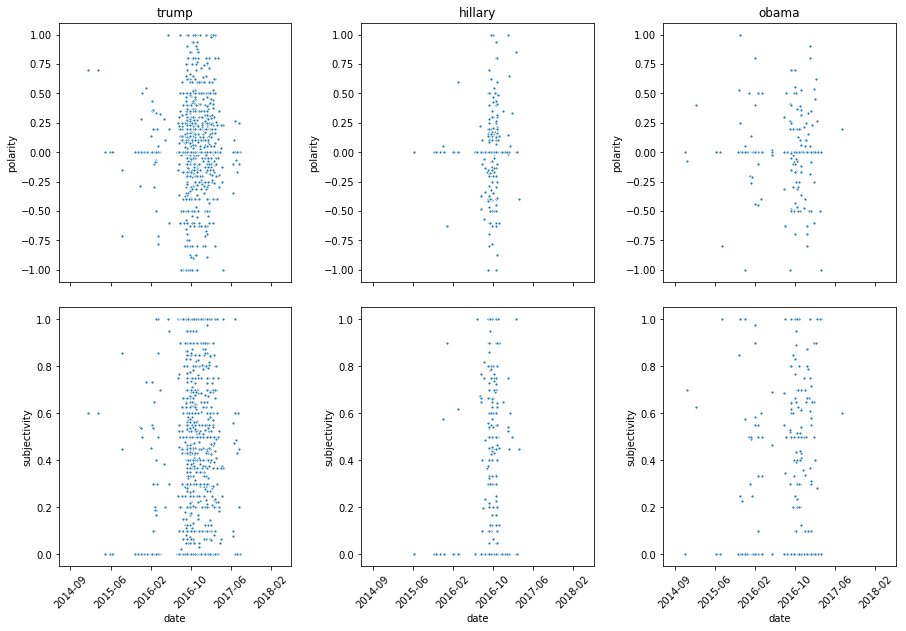

In [80]:
#keywords = ['trump', 'hillary', 'obama', 'bernie', 'fox', 'news']
keyword_frames = [tweets[tweets['text'].str.contains(keyword)] for keyword in keywords]
sentiments = ['polarity', 'subjectivity']

fig, axs = plt.subplots(ncols=len(keywords), nrows=len(sentiments), figsize=(15,10), sharex=True)
fig.subplots_adjust(hspace=0.1, wspace=(len(keywords)/10))

earliest = tweets['date'].min()

for idx2, s in enumerate(sentiments):
    for idx, frame in enumerate(keyword_frames):
        tmp = sns.scatterplot(x='date', y=s, data=frame, ax=axs[idx2, idx], marker='.')
        
        if idx2 % 2 == 0:
            tmp.set_title(keywords[idx])
            
        axs[idx2, idx].xaxis.set_major_locator(ticker.MultipleLocator(250))             
        axs[idx2, idx].set_xlim(left=earliest)
        axs[1, idx].tick_params(axis='x', rotation=45)

#### Visualizing average polarity per day, per keyword as defined above. Each keyword is plotted on a single graph with different colors.

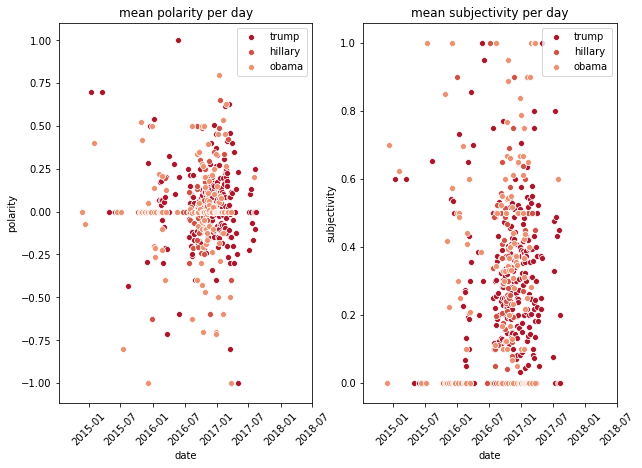

In [119]:
grouped = tweets.copy(deep=True)
grouped['date'] = [t.date() for t in tweets['date']] # converting date text to datetime obj

fig, axs = plt.subplots(ncols=len(sentiments), figsize=(10,7))#, sharex=True)
frames = [grouped[grouped['text'].str.contains(keyword)] for keyword in keywords]

sns.set_palette('RdBu', len(keywords))

for idx, sentiment in enumerate(sentiments):
    for keyword in keywords:
        frame = grouped[grouped['text'].str.contains(keyword)]
        grouped_dates = frame.groupby('date') # 'trump' frame grouped by 'date'
        mean_polarity = grouped_dates[sentiment].mean()
    
        plot = sns.scatterplot(mean_polarity.index, mean_polarity, label=keyword, ax=axs[idx])
        plot.set_xlim(left=earliest)
        
        #plot.set_title("mean {} per day".format(sentiment))
        axs[idx].tick_params(axis='x', rotation=45)
        axs[idx].set_title("mean {} per day".format(sentiment))

plt.legend(loc='upper right')
plt.show()